In [1]:
# Setup
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
%load_ext autoreload
%autoreload 2

(-1.0, 1.0)

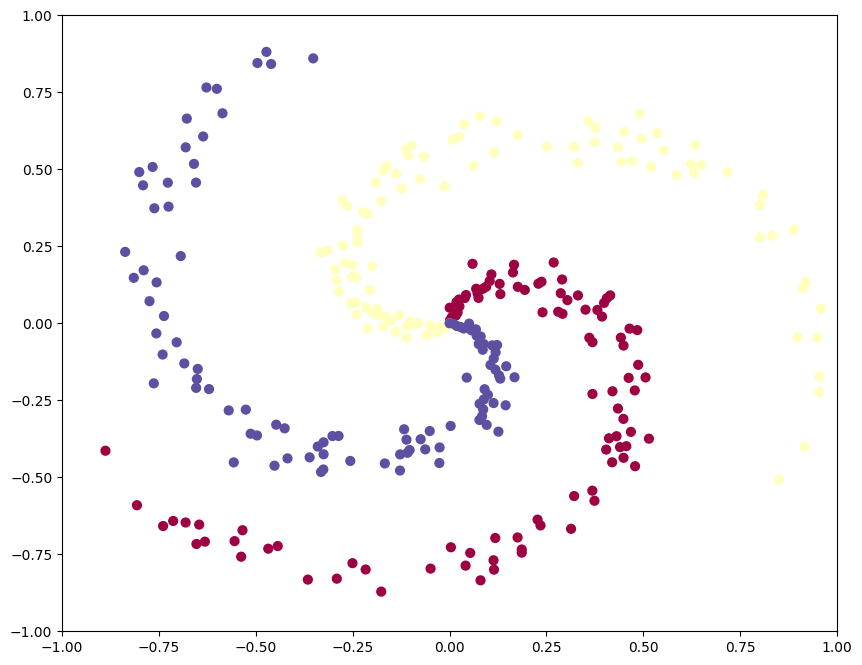

In [3]:
#generate random data -- not linearly separable

np.random.seed(0)
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D))
num_train_examples = X.shape[0]
y = np.zeros(N*K, dtype='uint8')
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
fig = plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim([-1,1])
plt.ylim([-1,1])



In [7]:
import numpy as np

def three_layer_net(NONLINEARITY, X, y, model, step_size, reg, num_iters=50000, print_every=1000):
    """
    Train a 3-layer NN (2 hidden layers) with ReLU or Sigmoid via vanilla GD.
    X: [N, D], y: [N] ints in [0..K-1]
    model: dict with W1,W2,W3,b1,b2,b3 and hidden sizes recorded in 'h','h2'
    """
    # unpack parameters
    h  = model['h']
    h2 = model['h2']
    W1 = model['W1']
    W2 = model['W2']
    W3 = model['W3']
    b1 = model['b1']
    b2 = model['b2']
    b3 = model['b3']

    N = X.shape[0]
    plot_array_1 = []
    plot_array_2 = []

    def relu(z): return np.maximum(0, z)
    def sigmoid(z): return 1.0 / (1.0 + np.exp(-z))
    def sigmoid_grad(a):  # a is already sigmoid(z)
        return a * (1.0 - a)

    for i in range(num_iters):
        # --------- FORWARD ---------
        if NONLINEARITY == 'RELU':
            hidden_layer  = relu(X.dot(W1) + b1)                 # [N, h]
            hidden_layer2 = relu(hidden_layer.dot(W2) + b2)      # [N, h2]
        elif NONLINEARITY == 'SIGM':
            hidden_layer  = sigmoid(X.dot(W1) + b1)
            hidden_layer2 = sigmoid(hidden_layer.dot(W2) + b2)
        else:
            raise ValueError("NONLINEARITY must be 'RELU' or 'SIGM'")

        scores = hidden_layer2.dot(W3) + b3                      # [N, K]

        # Stable softmax
        scores_shift = scores - scores.max(axis=1, keepdims=True)
        exp_scores = np.exp(scores_shift)
        probs = exp_scores / exp_scores.sum(axis=1, keepdims=True)   # [N, K]

        # --------- LOSS ----------
        correct_logprobs = -np.log(probs[np.arange(N), y])
        data_loss = correct_logprobs.mean()
        reg_loss = 0.5 * reg * (np.sum(W1*W1) + np.sum(W2*W2) + np.sum(W3*W3))
        loss = data_loss + reg_loss

        if i % print_every == 0:
            print(f"iteration {i}: loss {loss:.6f}")

        # --------- BACKWARD (dScores) ----------
        dscores = probs.copy()
        dscores[np.arange(N), y] -= 1
        dscores /= N                                                  # average over batch

        # W3, b3
        dW3 = hidden_layer2.T.dot(dscores) + reg * W3
        db3 = dscores.sum(axis=0, keepdims=True)

        # W2, b2 and backprop through nonlinearity
        if NONLINEARITY == 'RELU':
            dhidden2 = dscores.dot(W3.T)
            dhidden2[hidden_layer2 <= 0] = 0
        else:  # SIGM
            dhidden2 = dscores.dot(W3.T) * sigmoid_grad(hidden_layer2)

        dW2 = hidden_layer.T.dot(dhidden2) + reg * W2
        db2 = dhidden2.sum(axis=0, keepdims=True)

        # track gradient magnitude summaries (use means over entries)
        plot_array_2.append(np.mean(np.abs(dW2)))

        # W1, b1
        if NONLINEARITY == 'RELU':
            dhidden = dhidden2.dot(W2.T)
            dhidden[hidden_layer <= 0] = 0
        else:  # SIGM
            dhidden = dhidden2.dot(W2.T) * sigmoid_grad(hidden_layer)

        dW1 = X.T.dot(dhidden) + reg * W1
        db1 = dhidden.sum(axis=0, keepdims=True)

        plot_array_1.append(np.mean(np.abs(dW1)))

        # --------- PARAMETER UPDATE ---------
        W1 -= step_size * dW1
        b1 -= step_size * db1
        W2 -= step_size * dW2
        b2 -= step_size * db2
        W3 -= step_size * dW3
        b3 -= step_size * db3

    # --------- TRAIN ACCURACY ----------
    if NONLINEARITY == 'RELU':
        hidden_layer  = relu(X.dot(W1) + b1)
        hidden_layer2 = relu(hidden_layer.dot(W2) + b2)
    else:
        hidden_layer  = sigmoid(X.dot(W1) + b1)
        hidden_layer2 = sigmoid(hidden_layer.dot(W2) + b2)

    scores = hidden_layer2.dot(W3) + b3
    y_pred = np.argmax(scores, axis=1)
    acc = np.mean(y_pred == y)
    print(f"training accuracy: {acc:.2f}")

    # pack back into model (optional)
    model.update({'W1': W1, 'W2': W2, 'W3': W3, 'b1': b1, 'b2': b2, 'b3': b3})

    return plot_array_1, plot_array_2, W1, W2, W3, b1, b2, b3


In [9]:
def clip(grads, max_norm=5.0):
    total = 0.0
    for g in grads:
        total += np.sum(g*g)
    total = np.sqrt(total)
    if total > max_norm:
        scale = max_norm / (total + 1e-8)
        for g in grads:
            g *= scale
# then before updates:
#clip([dW1, db1, dW2, db2, dW3, db3], max_norm=5.0)


In [10]:
def relu(z): return np.maximum(0, z)
def sigmoid(z): return 1.0 / (1.0 + np.exp(-z))
def sigmoid_grad(a): return a * (1.0 - a)   # 'a' is sigmoid(z)

### Network Architecture (Sigmoid Activation)

| Layer            | Weights / Bias | Dimensions            | Description                                                                 |
| ---------------- | -------------- | --------------------- | --------------------------------------------------------------------------- |
| Input            | `W1`, `b1`     | `(D, h)` / `(1, h)`   | Projects input features of dimension `D` into hidden layer 1 of size `h`.   |
| Hidden 1 (Sigmoid) | `W2`, `b2`   | `(h, h2)` / `(1, h2)` | Projects from hidden layer 1 to hidden layer 2 using the Sigmoid function.  |
| Hidden 2 (Sigmoid) | `W3`, `b3`   | `(h2, K)` / `(1, K)`  | Projects to output layer with `K` classes using the final Sigmoid output.   |


In [ ]:
h = 50
h2 = 50

model = {
    'h': h,
    'h2': h2,
    'W1': 0.1 * np.random.randn(D, h),
    'b1': np.zeros((1, h)),
    'W2': 0.1 * np.random.randn(h, h2),
    'b2': np.zeros((1, h2)),
    'W3': 0.1 * np.random.randn(h2, K),
    'b3': np.zeros((1, K)),
}

# Sigmoid can train; ReLU is usually easier. Start with a modest step size.
sigm_array_1, sigm_array_2, s_W1, s_W2, s_W3, s_b1, s_b2, s_b3 = three_layer_net(
    'SIGM', X, y, model, step_size=1e-1, reg=1e-3
)


### Network Architecture

| Layer           | Weights / Bias | Dimensions            | Description                                                               |
| --------------- | -------------- | --------------------- | ------------------------------------------------------------------------- |
| Input           | `W1`, `b1`     | `(D, h)` / `(1, h)`   | Projects input features of dimension `D` into hidden layer 1 of size `h`. |
| Hidden 1 (ReLU) | `W2`, `b2`     | `(h, h2)` / `(1, h2)` | Projects from hidden layer 1 to hidden layer 2.                           |
| Hidden 2 (ReLU) | `W3`, `b3`     | `(h2, K)` / `(1, K)`  | Projects to output layer with `K` classes.                                |


In [ ]:
model = {}
model['h'] = h      # hidden layer 1 size
model['h2'] = h2    # hidden layer 2 size

# Initialize weights with small random values (helps break symmetry)
model['W1'] = 0.1 * np.random.randn(D, h)
model['b1'] = np.zeros((1, h))

model['W2'] = 0.1 * np.random.randn(h, h2)
model['b2'] = np.zeros((1, h2))

model['W3'] = 0.1 * np.random.randn(h2, K)
model['b3'] = np.zeros((1, K))

(relu_array_1, relu_array_2,
 r_W1, r_W2, r_W3,
 r_b1, r_b2, r_b3) = three_layer_net('RELU', X, y, model,
                                     step_size=1e-1, reg=1e-3)


# Vanishing Gradient (Practical Heuristic)

### Idea
Track the **magnitude of gradients** for the hidden-to-hidden (or hidden-to-next) weight matrices as a quick proxy for *how much the network is learning* at each layer and step.

- If the **gradient norms** are consistently **very small**, information from earlier timesteps/layers isn’t updating the weights → **vanishing gradients**.
- If they **blow up**, you’re seeing **exploding gradients** (→ use **gradient clipping**).
- Normalize by the number of parameters (or neurons) for fair comparison across layers or layer widths.

---

### Useful Metrics (pick one and be consistent)

#### **1⃣ Per-layer mean |grad|**
$$
\frac{1}{|W|} \sum |\frac{\partial L}{\partial W}|
$$

#### **2 Per-layer Frobenius norm**
$$
\lVert \frac{\partial L}{\partial W} \rVert_F
$$

#### **3 Per-neuron (row-wise) norm for granularity**
$$
\lVert \frac{\partial L}{\partial W_{i,:}} \rVert_2
$$

---

###  NOTE
> Gradient magnitude ≠ guaranteed learning progress — it depends on the scale, curvature, and learning rate.
> But as a **trend signal**, it’s highly useful for detecting **vanishing** or **exploding** gradient behavior during training.

---


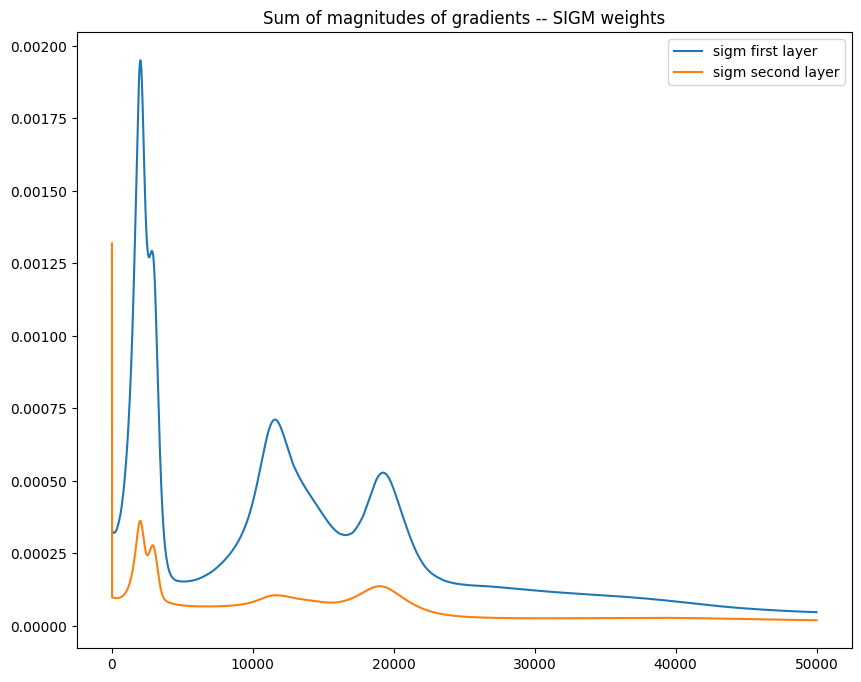

In [13]:
plt.plot(np.array(sigm_array_1))
plt.plot(np.array(sigm_array_2))
plt.title('Sum of magnitudes of gradients -- SIGM weights')
plt.legend(("sigm first layer", "sigm second layer"))



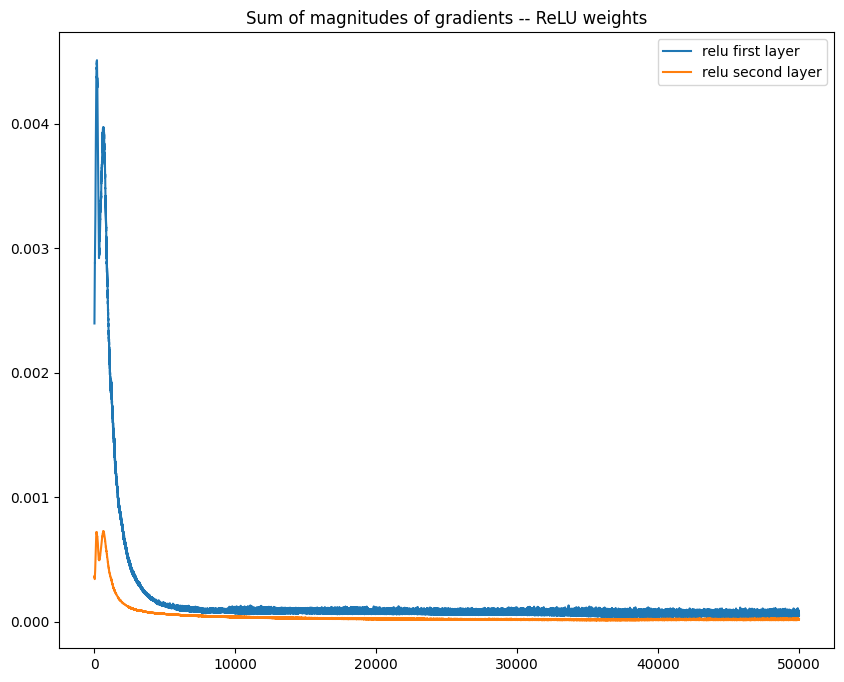

In [14]:
plt.plot(np.array(relu_array_1))
plt.plot(np.array(relu_array_2))
plt.title('Sum of magnitudes of gradients -- ReLU weights')
plt.legend(("relu first layer", "relu second layer"))

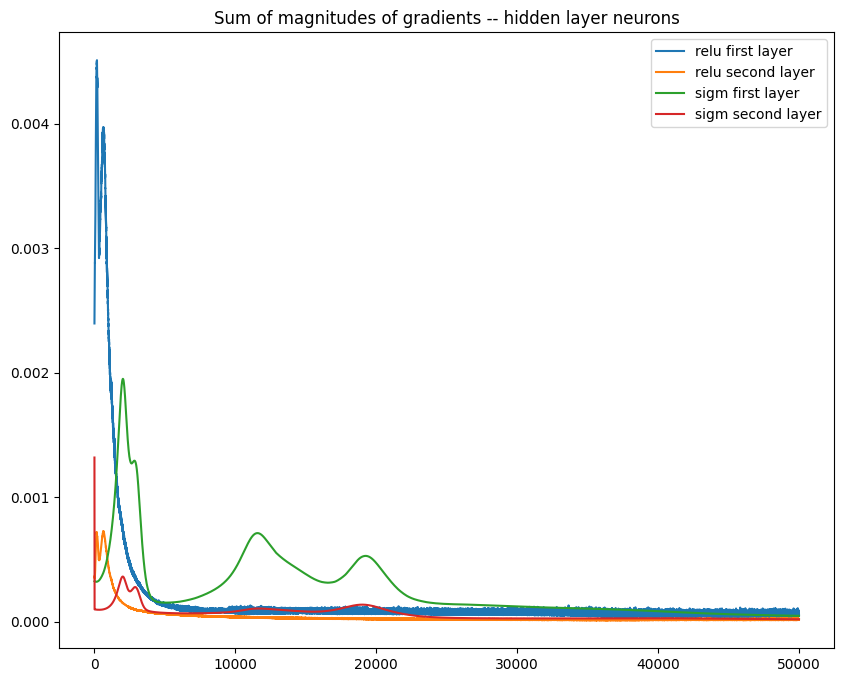

In [15]:
# Overlaying the two plots to compare
plt.plot(np.array(relu_array_1))
plt.plot(np.array(relu_array_2))
plt.plot(np.array(sigm_array_1))
plt.plot(np.array(sigm_array_2))
plt.title('Sum of magnitudes of gradients -- hidden layer neurons')
plt.legend(("relu first layer", "relu second layer","sigm first layer", "sigm second layer"))